# pix2pix 

## Model 설계

### Library for Model construction
```python
import tensorflow as tf
import numpy as np

print(tensorflow.__version__) # Tensorflow : 2.6.0
print(np.__version__) # Numpy : 1.21.4 

```

### Directory structure

```bash
aiffel
└── cityscapes_generation
    ├── project14.ipynb   <─ I am here
    └── data
        ├── cityscapes.zip
        └── cityscapes
            ├── train # 1000 images
            │   ├── 1.jpg
            │   ├── 2.jpg
            │   ├── ...
            │   └── 1000.jpg
            └── val   # 5 images
                ├── 1.jpg
                ├── 2.jpg
                ├── 3.jpg
                ├── 4.jpg
                └── 5.jpg
```

In [1]:
import tensorflow as tf
from tensorflow import image
from tensorflow import data
from tensorflow.keras.preprocessing.image import random_rotation
from tensorflow.keras import layers, Input, Model

import numpy as np

#print(tf.__version__)
#print(np.__version__)

In [2]:
# Path to training data
train_data_path = 'data/cityscapes/train/'
# Path to Validation data
val_data_path = 'data/cityscapes/val/'

### Library for image processing
```python
import cv2
import matplotlib.pyplot as plt

print(cv2.__version__) # cv2 : 4.5.3
# import matplotlib
# print(matplotlib.__version__) # matplotblib : 3.4.3 

```

In [3]:
import cv2
import matplotlib.pyplot as plt
import os

#print(cv2.__version__) # cv2 : 4.5.3
#print(matplotlib.__version__) # matplotlib : 3.4.3

### Showing a sample of training images

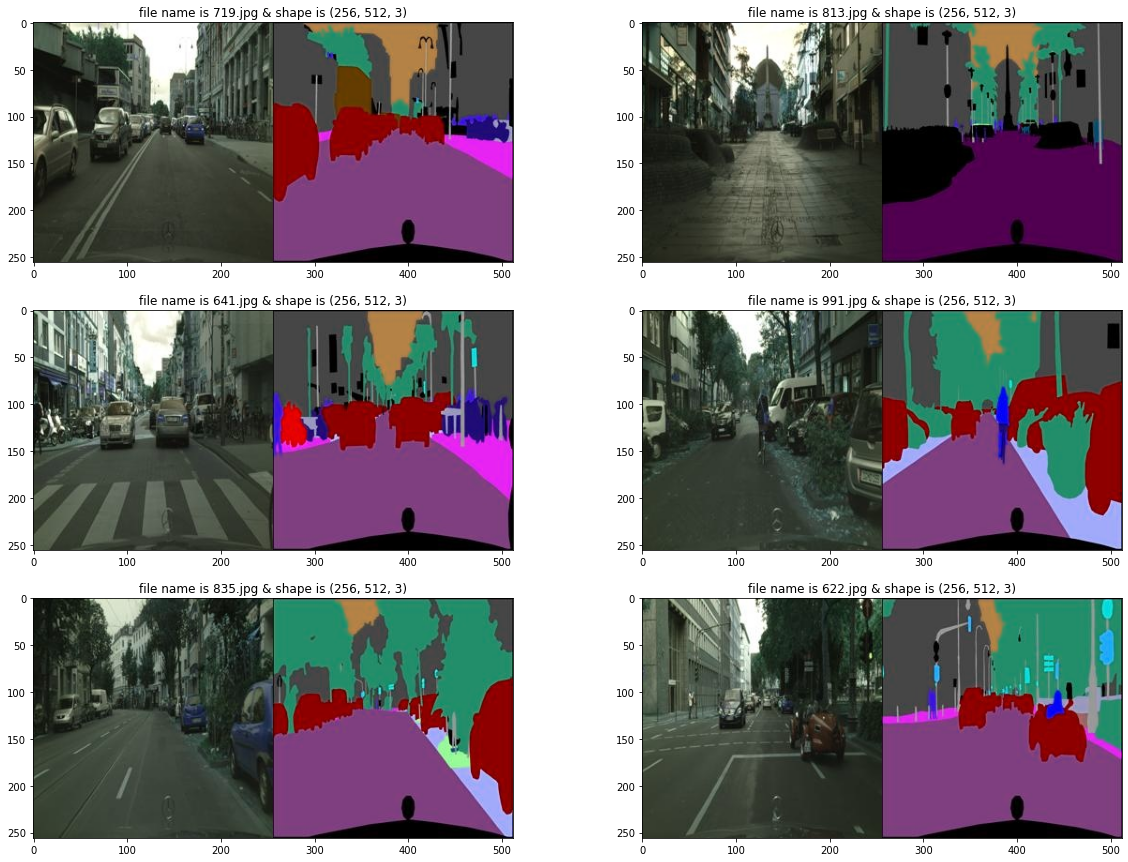

In [4]:
plt.figure(figsize=(20, 15))
for i in range(1, 7):
    f = train_data_path + os.listdir(train_data_path)[np.random.randint(1000)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3, 2, i)
    plt.title(f"file name is {f.split('/')[3]} & shape is {img.shape}")
    plt.imshow(img)

In [5]:
class Img_preprosessing():
    
    def __init__(self, img_path, img=None):
        self.img_path = img_path
        # self.img = tf.io.read_file(self.img_path)
        # self.img = tf.image.decode_image(self.img, 3)
        
    def normalize(self, x):
        x = tf.cast(x, tf.float32)
        return (x/127.5) - 1
    
    def denormalize(self, x):
        x = (x+1) * 127.5
        x = x.numpy()
        return x.astype(np.uint8)
    
    def load_img(self, x):
        img = tf.io.read_file(x)
        img = tf.image.decode_image(img, 3)

        w = tf.shape(img)[1] // 2
        src = img[:, :w, :] 
        src = tf.cast(src, tf.float32)
        seg = img[:, w:, :] 
        seg = tf.cast(seg, tf.float32)
        return self.normalize(src), self.normalize(seg)
    
    def split_shape(self, x):
        img = tf.io.read_file(x)
        img = tf.image.decode_image(img, 3)
        w = tf.shape(img)[1] // 2
        src = img[:, :w, :]
        src = tf.cast(src, tf.float32)
        src = self.normalize(src)
        seg = img[:, w:, :]
        seg = tf.cast(seg, tf.float32)
        seg = self.normalize(seg)
        ag_src, ag_seg = self.apply_augmentation(src, seg)
        
        #src, seg = self.normalize(src), self.normalize(seg)
        return ag_src, ag_seg
    
    @tf.function()
    def apply_augmentation(self, src, seg):
        stacked = tf.concat([src, seg], axis=-1)

        _pad = tf.constant([[30,30],[30,30],[0,0]])
        if tf.random.uniform(()) < .5:
            padded = tf.pad(stacked, _pad, "REFLECT")
        else:
            padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

        out = image.random_crop(padded, size=[256, 256, 6])

        out = image.random_flip_left_right(out)
        out = image.random_flip_up_down(out)

        if tf.random.uniform(()) < .5:
            degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
            out = image.rot90(out, k=degree)

        return out[...,:3], out[...,3:]   
    
    def get_train(self, x):
        src, seg = self.load_img(x)
        src, seg = self.apply_augmentation(src, seg)
        return src, seg

In [6]:
aa = Img_preprosessing(train_data_path)

In [7]:
train_images = data.Dataset.list_files(train_data_path + '*.jpg')
train_images = train_images.map(aa.get_train).shuffle(100).batch(4)

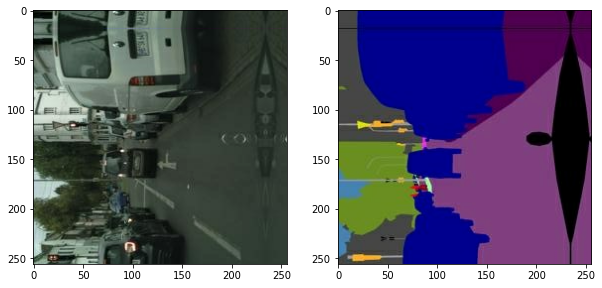

In [8]:
sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
ag_src, ag_seg = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(ag_src[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(ag_seg[0].astype(np.uint8))

### Generator

#### U-Net Generator Architecture
![](https://www.researchgate.net/publication/349487608/figure/fig4/AS:1017165721378817@1619522614571/The-network-structure-of-pix2pix-including-the-structure-of-U-Net.png)

Encoder : `[64, 128, 256, 512, 512, 512, 512, 512]`  
Decoder : `[512, 512, 512, 512, 256, 128, 64]`

In [9]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

In [10]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [11]:
UNetGenerator().get_summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block (EncodeBlock)      (None, 128, 128, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
encode_block_1 (EncodeBlock)    (None, 64, 64, 128)  131584      encode_block[0][0]               
__________________________________________________________________________________________________
encode_block_2 (EncodeBlock)    (None, 32, 32, 256)  525312      encode_block_1[0][0]             
______________________________________________________________________________________________

### Discriminator

Discriminator : `[64, 128, 512, 512, 1]`

In [12]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

In [13]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        filters = [64,128,256,512,1]
        self.sigmoid = layers.Activation("sigmoid")
        self.blocks = [layers.Concatenate()]
        # For문을 활용해서 DiscBlock을 쌓아주세요.
        # 조건 1 : 3번째까지 stride는 2로 주되 이후에는 1로 주세요
        # 조건 2 : 3번째까지 custom padding을 주지 않아도 되는데 이후에는 주세요.
        # 조건 3: 1번째와 5번째에서는 Batch Normalization을 사용하지 마세요.
        # 조건 4 : 1번째부터 4번째까지 LeakyReLU를 적용하고 마지막에는 sigmoid를 적용하세요. (sigmoid의 경우 따로 정의해야 합니다)
        for i, v in enumerate(filters):
            self.blocks.append(DiscBlock(n_filters=v,
                      stride=2 if i <3 else 1,
                      custom_pad=False if i <3 else True,
                      use_bn=True if i !=0 and i !=4 else False,
                      act=True if i<4 else False
                      ))


    def call(self, x, y):
        for i, block in enumerate(self.blocks):
            if i == 0:
                out = block([x, y])
            else:
                out = block(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

In [14]:
Discriminator().get_summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

### Model Training

In [15]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

In [16]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

In [17]:
@tf.function
def train_step(seg, real_cityscapes):
    # 이전에 배웠던 내용을 토대로 train_step을 구성해주세요.
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_cityscapes = generator(seg, training=True)
        # Discriminator 예측
        fake_disc = discriminator(seg, fake_cityscapes, training=True)
        real_disc = discriminator(seg, real_cityscapes, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_cityscapes, real_cityscapes, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

In [18]:
generator = UNetGenerator()
discriminator = Discriminator()

#### 10 Epochs training

In [19]:
EPOCHS = 10

for epoch in range(1, EPOCHS+1):
    for i, (_src, _seg) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(_seg, _src)
                
        # 100회 반복마다 손실을 출력합니다.
        if (i+1) % 100 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[100]                     
Generator_loss:0.8699                     
L1_loss:0.2195                     
Discriminator_loss:0.9922

EPOCH[1] - STEP[200]                     
Generator_loss:1.7600                     
L1_loss:0.1916                     
Discriminator_loss:0.8744

EPOCH[2] - STEP[100]                     
Generator_loss:2.2046                     
L1_loss:0.1661                     
Discriminator_loss:0.5679

EPOCH[2] - STEP[200]                     
Generator_loss:1.4300                     
L1_loss:0.1562                     
Discriminator_loss:0.7677

EPOCH[3] - STEP[100]                     
Generator_loss:2.0113                     
L1_loss:0.1612                     
Discriminator_loss:0.8674

EPOCH[3] - STEP[200]                     
Generator_loss:0.7624                     
L1_loss:0.1711                     
Discriminator_loss:1.3491

EPOCH[4] - STEP[100]                     
Generator_loss:1.4554                     
L1_loss:0.1962             

In [20]:
val = Img_preprosessing(val_data_path)

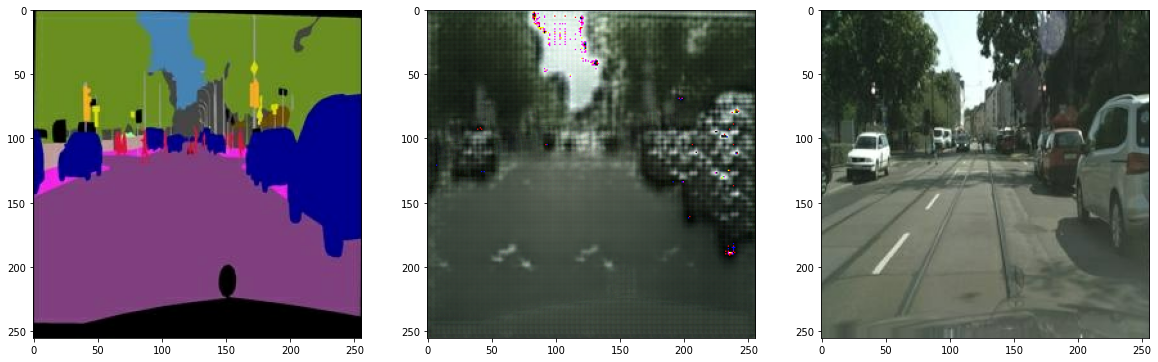

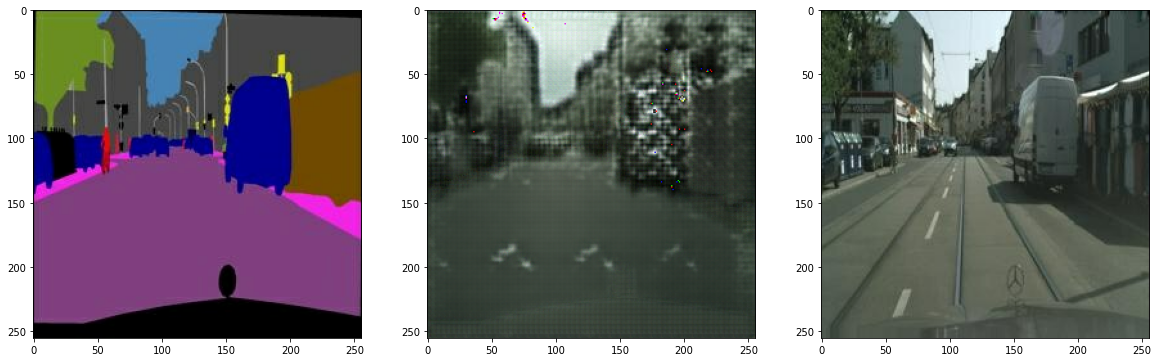

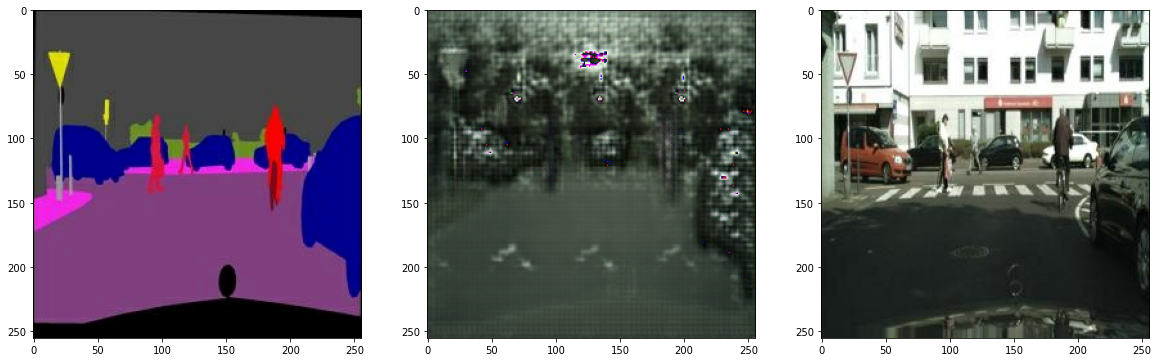

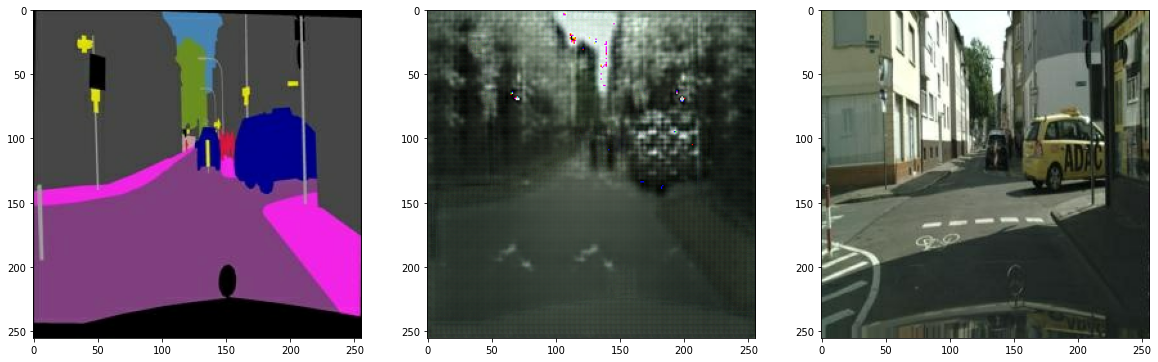

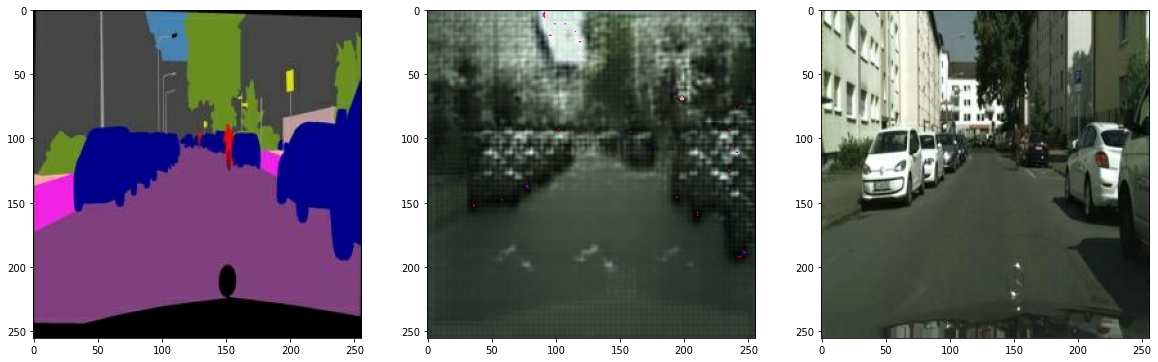

In [21]:
for test_ind in range(len(os.listdir(val_data_path))):
    f = val_data_path + os.listdir(val_data_path)[test_ind]
    v_src, v_seg = val.load_img(f)

    pred = generator(tf.expand_dims(v_seg, 0))
    pred = val.denormalize(pred)

    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1); plt.imshow(val.denormalize(v_seg))
    plt.subplot(1,3,2); plt.imshow(pred[0])
    plt.subplot(1,3,3); plt.imshow(val.denormalize(v_src))

### Model Training

#### 40 epoch 추가 학습
Totally training history of 50 epochs

In [22]:
EPOCHS = 40

for epoch in range(1, EPOCHS+1):
    for i, (_src, _seg) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(_seg, _src)
                
        # 100회 반복마다 손실을 출력합니다.
        if (i+1) % 100 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[100]                     
Generator_loss:0.8579                     
L1_loss:0.1509                     
Discriminator_loss:1.5244

EPOCH[1] - STEP[200]                     
Generator_loss:1.4813                     
L1_loss:0.1854                     
Discriminator_loss:0.7435

EPOCH[2] - STEP[100]                     
Generator_loss:0.5064                     
L1_loss:0.1964                     
Discriminator_loss:1.0904

EPOCH[2] - STEP[200]                     
Generator_loss:0.6978                     
L1_loss:0.1530                     
Discriminator_loss:1.2269

EPOCH[3] - STEP[100]                     
Generator_loss:1.4594                     
L1_loss:0.2017                     
Discriminator_loss:0.3815

EPOCH[3] - STEP[200]                     
Generator_loss:1.1284                     
L1_loss:0.1820                     
Discriminator_loss:0.5663

EPOCH[4] - STEP[100]                     
Generator_loss:1.8733                     
L1_loss:0.1864             

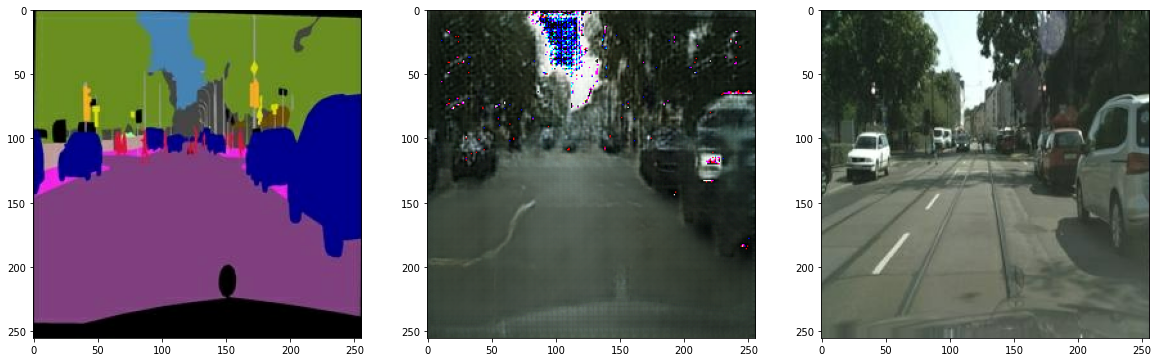

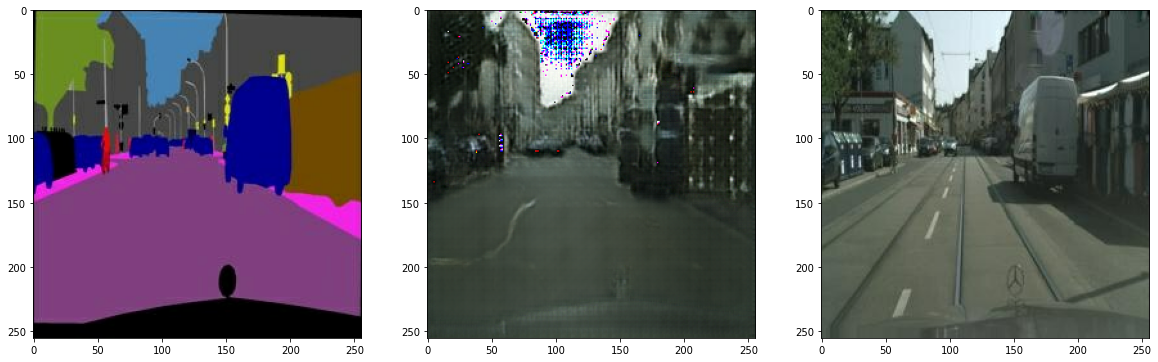

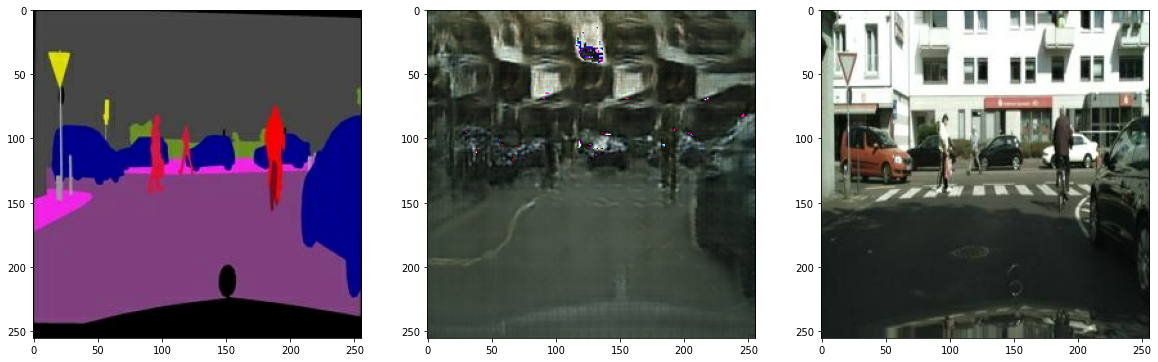

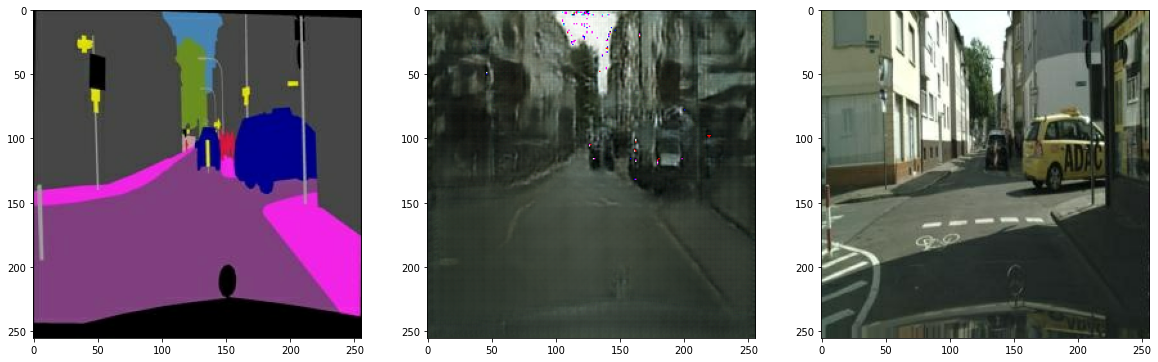

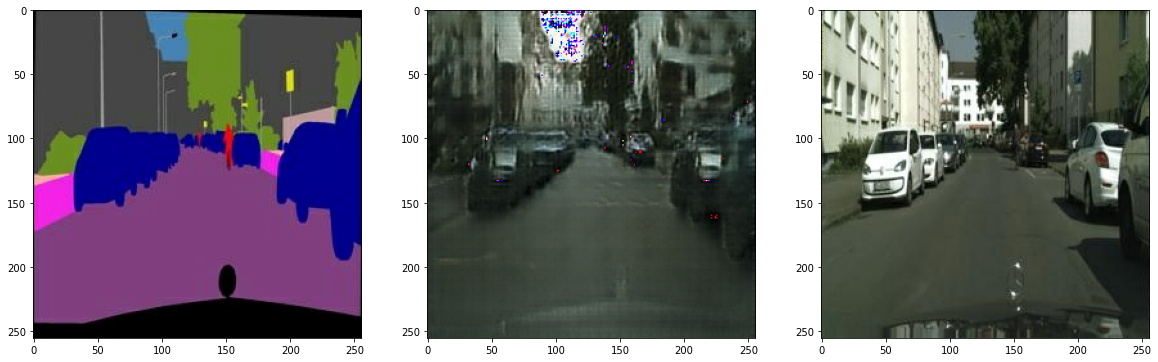

In [23]:
for test_ind in range(len(os.listdir(val_data_path))):
    f = val_data_path + os.listdir(val_data_path)[test_ind]
    v_src, v_seg = val.load_img(f)

    pred = generator(tf.expand_dims(v_seg, 0))
    pred = val.denormalize(pred)

    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1); plt.imshow(val.denormalize(v_seg))
    plt.subplot(1,3,2); plt.imshow(pred[0])
    plt.subplot(1,3,3); plt.imshow(val.denormalize(v_src))